In [2]:
%pip install matplotlib

     ---------------------------------------- 8.1/8.1 MB 30.6 MB/s eta 0:00:00
     ---------------------------------------- 225.2/225.2 kB ? eta 0:00:00
  Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
     ---------------------------------------- 2.3/2.3 MB 48.3 MB/s eta 0:00:00
     ---------------------------------------- 73.8/73.8 kB 4.0 MB/s eta 0:00:00
     ---------------------------------------- 7.0/7.0 MB 21.3 MB/s eta 0:00:00
     -------------------------------------- 113.9/113.9 kB 6.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip available: 22.3 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import numpy as np
import time
import math
import matplotlib.pyplot as plt
from numba import vectorize, float64

# Configuration pour des graphiques plus lisibles
plt.style.use('ggplot')

print("Bibliothèques chargées. Prêt pour le challenge.")

Bibliothèques chargées. Prêt pour le challenge.


In [4]:
# --- Partie 1 : Implémentation NumPy Standard ---
def calcul_numpy_standard(arr):
    """
    Version standard avec NumPy.
    Crée des tableaux temporaires pour chaque opération intermédiaire.
    """
    terme1 = np.sin(arr**2)
    terme2 = np.cos(2 * arr)
    terme3 = np.exp(-arr / 10)
    terme4 = np.log(np.abs(arr) + 1)
    terme5 = arr**2 + 1
    
    # Combinaison finale
    resultat = terme1 + terme2 * terme3 + terme4 / terme5
    return resultat

# --- Partie 2 : uFunc Personnalisée avec Numba ---
# target='parallel' permet d'utiliser tous les coeurs du CPU
@vectorize([float64(float64)], nopython=True, target='parallel')
def ufunc_optimisee(x):
    """
    uFunc personnalisée optimisée.
    Compile le code en langage machine et exécute élément par élément
    sans créer de tableaux intermédiaires (fusion de boucles).
    """
    x_carre = x * x
    
    # Utilisation des fonctions scalaires du module 'math'
    sin_term = math.sin(x_carre)
    cos_term = math.cos(2 * x)
    exp_term = math.exp(-x / 10)
    log_term = math.log(abs(x) + 1)
    denom = x_carre + 1
    
    return sin_term + cos_term * exp_term + log_term / denom

print("Fonctions définies et compilées.")

Fonctions définies et compilées.


In [5]:
def benchmark_complet():
    sizes = [10**5, 10**6, 10**7, 2*10**7] # J'ai réduit le dernier à 20M pour éviter le crash mémoire sur petits PC
    
    results_std = []
    results_ufunc = []
    sizes_log = []

    print("=== BENCHMARK NumPy vs uFuncs ===")
    print(f"{'Taille':<12} {'NumPy (s)':<12} {'uFunc (s)':<12} {'Speedup':<10}")
    print("-" * 50)
    
    for size in sizes:
        # Génération des données
        arr = np.random.randn(size)
        
        # 1. Version NumPy standard
        start = time.time()
        res_std = calcul_numpy_standard(arr)
        time_std = time.time() - start
        
        # 2. Version uFunc (Premier appel peut inclure un temps de compilation minime)
        start = time.time()
        res_ufunc = ufunc_optimisee(arr)
        time_ufunc = time.time() - start
        
        # Vérification (Exactitude)
        diff_max = np.max(np.abs(res_std - res_ufunc))
        
        # Calcul du Speedup
        speedup = time_std / time_ufunc
        
        # Stockage pour le graphique
        results_std.append(time_std)
        results_ufunc.append(time_ufunc)
        sizes_log.append(size)
        
        print(f"{size:<12} {time_std:<12.4f} {time_ufunc:<12.4f} {speedup:<10.2f}x")
        
        if diff_max > 1e-10:
            print(f"⚠️ Attention : Différence max détectée : {diff_max:.2e}")

    return sizes_log, results_std, results_ufunc

# Lancement du benchmark
sizes, t_std, t_ufunc = benchmark_complet()

=== BENCHMARK NumPy vs uFuncs ===
Taille       NumPy (s)    uFunc (s)    Speedup   
--------------------------------------------------
100000       0.0100       0.0065       1.53      x
1000000      0.0755       0.0170       4.44      x
10000000     1.1107       0.2381       4.67      x
20000000     2.3240       0.4242       5.48      x


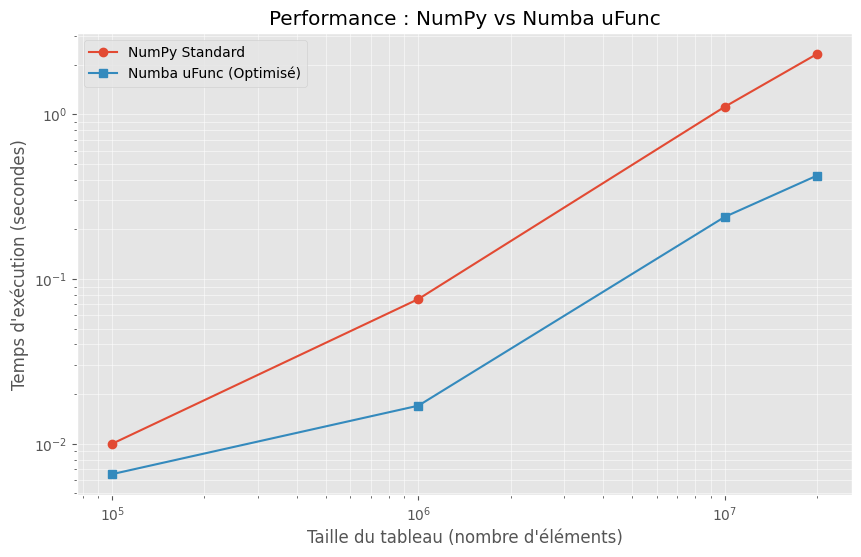

In [6]:
# Tracé du graphique comparatif
plt.figure(figsize=(10, 6))
plt.plot(sizes, t_std, marker='o', label='NumPy Standard')
plt.plot(sizes, t_ufunc, marker='s', label='Numba uFunc (Optimisé)')

plt.title('Performance : NumPy vs Numba uFunc')
plt.xlabel('Taille du tableau (nombre d\'éléments)')
plt.ylabel('Temps d\'exécution (secondes)')
plt.xscale('log') # Échelle logarithmique pour mieux voir les ordres de grandeur
plt.yscale('log')
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.legend()
plt.show()

In [7]:
print("--- Applications Avancées & Machine Learning ---")

# 1. Gradient Numérique (Question 3)
# Note : Ici on simule f(x+h) et f(x-h) comme entrées pour simplifier l'exemple vectorisé
@vectorize([float64(float64, float64, float64)], nopython=True)
def gradient_numerique(f_x_plus, f_x_minus, h):
    return (f_x_plus - f_x_minus) / (2 * h)

# 2. MSE Loss (Question 4)
@vectorize([float64(float64, float64)], nopython=True)
def mse_loss(y_true, y_pred):
    return (y_true - y_pred) ** 2

# 3. Dérivée Sigmoïde (Question 4)
@vectorize([float64(float64)], nopython=True)
def sigmoid_derivative(x):
    # Formule : sig * (1 - sig)
    # math.exp est beaucoup plus rapide que np.exp dans une boucle Numba
    sig = 1.0 / (1.0 + math.exp(-x))
    return sig * (1.0 - sig)

# 4. Extension : Multi-paramètres et Sécurité
@vectorize([float64(float64)], nopython=True)
def ufunc_securisee(x):
    if x == 0:
        return 0.0  # Gestion de l'erreur div/0
    return math.log(abs(x)) / x

# --- Petit Test Rapide ---
data = np.random.randn(5)
print(f"Données : {data}")
print(f"Dérivée Sigmoïde : {sigmoid_derivative(data)}")
print(f"MSE (vs 0) : {mse_loss(data, np.zeros(5))}")

--- Applications Avancées & Machine Learning ---
Données : [ 1.59555112  0.0281136   0.2489602  -0.08511457 -0.28155444]
Dérivée Sigmoïde : [0.14017691 0.24995061 0.24616585 0.24954777 0.24511018]
MSE (vs 0) : [2.54578338e+00 7.90374379e-04 6.19811793e-02 7.24448970e-03
 7.92729049e-02]
